In this notebook, we will try to build a very simple model to predict the outcome of tennis matched.  This is an ELO model.  Specifically, we will model

$$p(y_1) = \sigma(\beta_1 - \beta_2)$$, where $$\beta_1$$ and $$\beta_2$$ are coefficients for players 1 and 2 respectively

In [1]:
from infra.defs import DATA_DIR
import pandas as pd
import os

match_result_dir = os.path.join(DATA_DIR, 'match_results')

df = pd.concat([
    pd.read_csv(os.path.join(match_result_dir, f)) for f in os.listdir(match_result_dir)
])

In [2]:
df.rename(columns={x: x.lower() for x in df.columns}, inplace=True)

In [3]:
# Drop rows with no result

df.dropna(subset=['winner', 'loser'], inplace=True)

In [4]:
df.shape

(50784, 59)

50k matches to work with

In [5]:
df['match_id'] = range(df.shape[0])

In [6]:
# Convert dates to datetimes
df['date'] = pd.to_datetime(df['date']).astype(pd.Timestamp)

#### Explore Player Frequencies

In [7]:
df['winner'] = df['winner'].map(lambda x: x.strip())
df['loser'] = df['loser'].map(lambda x: x.strip())
player_set = set(df['winner']) | set(df['loser'])
n_players = len(player_set)
n_players

1396

In [8]:
sorted(player_set)

['Abdulla M.',
 'Abel M.',
 'Acasuso J.',
 'Adaktusson J.',
 'Agaev E.',
 'Agassi A.',
 'Agenor R.',
 'Ager J.',
 'Agostinelli B.',
 'Aguilar J.',
 'Ahouda A.',
 'Al Ghareeb M.',
 'Al Khulaifi N.G.',
 'Al Mutawa J.',
 'Al-Alawi S.K.',
 'Al-Ghareeb M.',
 'Alami K.',
 'Alawadhi O.',
 'Albert M.',
 'Albot R.',
 'Alcaide G.',
 'Aldi F.',
 'Ali Mutawa J.M.',
 'Allegro Y.',
 'Almagro N.',
 'Alonso J.',
 'Altamirano C.',
 'Altmaier D.',
 'Alund M.',
 'Alvarez E.',
 'Alves T.',
 'Amritraj P.',
 'Ancic I.',
 'Ancic M.',
 'Andersen J.',
 'Andersen J.F.',
 'Anderson A.',
 'Anderson K.',
 'Anderson O.',
 'Andersson H.',
 'Andreev A.',
 'Andreev I.',
 'Andreozzi G.',
 'Androic T.',
 'Andujar P.',
 'Aragone J.',
 'Aranguren J.M.',
 'Arazi H.',
 'Arguello F.',
 'Armando H.',
 'Arnaboldi A.',
 'Arnold L.',
 'Arquez P.',
 'Arthurs W.',
 'Artunedo Martinavarro A.',
 'Arvidsson I.',
 'Ascione A.',
 'Ascione T.',
 'Auckland J.',
 'Auger-Aliassime F.',
 'Authom M.',
 'Awadhy O.',
 'Ayala D.',
 'Azzaro L.',

1396 total players.  Let's look at player frequency:

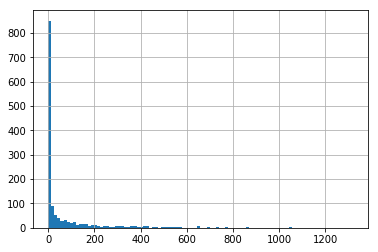

In [9]:
%matplotlib inline
all_players = pd.Series(df['winner'].tolist() + df['loser'].tolist())
all_players.value_counts().hist(bins=100)

There is clearly a long tail.  There are certain players that have played a lot of matches over this time period, and lots of players with very few

In [10]:
all_players.value_counts().value_counts().head()

1    314
2    163
3     84
4     59
5     49
dtype: int64

In [11]:
all_players.value_counts().head(20)

Federer R.          1318
Nadal R.            1051
Ferrer D.           1042
Djokovic N.          919
Berdych T.           888
Youzhny M.           865
Robredo T.           864
Lopez F.             858
Verdasco F.          854
Murray A.            806
Davydenko N.         794
Gasquet R.           773
Roddick A.           773
Kohlschreiber P.     730
Hewitt L.            727
Simon G.             724
Wawrinka S.          701
Nieminen J.          697
Haas T.              691
Ferrero J.C.         683
dtype: int64

The players who appear most often are the best players...

#### Get player indices

In [12]:
player_idx_dict = dict(list(enumerate(player_set)))
player_mapping = {v: k for k, v in player_idx_dict.iteritems()}

In [13]:
n_players = len(player_mapping)
n_players

1396

In [14]:
df['winner_idx'] = df['winner'].map(lambda x: player_mapping[x])
df['loser_idx'] = df['loser'].map(lambda x: player_mapping[x])

#### Set up training data

First, we'll just try training on everything in this time period and see what happens.  Later, we will split into train and test sets and figure out appropriate discounting, etc.

In [15]:
from scipy.sparse import csc_matrix
import numpy as np


N_PLAYERS = len(player_mapping)

def _get_sparse_X(df):
    n = df.shape[0]
    p1_data = np.ones(n)
    p1_row = np.arange(n)
    p1_col = df['p1_idx'].values

    p2_data = -np.ones(n)
    p2_row = np.arange(n)
    p2_col = df['p2_idx'].values

    all_data = np.concatenate([p1_data, p2_data])
    all_row = np.concatenate([p1_row, p2_row])
    all_col = np.concatenate([p1_col, p2_col])

    X = csc_matrix((all_data, (all_row, all_col)), shape=(n, N_PLAYERS))
    return X


def _randomize_result(df):
    df['__chooser__'] = np.random.binomial(1, 0.5, size=df.shape[0])
    df['p1_idx'] = df.apply(
        lambda row: row['winner_idx'] if row['__chooser__'] == 1 else row['loser_idx'],
        axis=1
    )
    df['p2_idx'] = df.apply(
        lambda row: row['winner_idx'] if row['__chooser__'] == 0 else row['loser_idx'],
        axis=1
    )
    df['p1_rank'] = df.apply(
        lambda row: row['wrank'] if row['__chooser__'] == 1 else row['lrank'],
        axis=1
    )
    df['p2_rank'] = df.apply(
        lambda row: row['wrank'] if row['__chooser__'] == 0 else row['lrank'],
        axis=1
    )
    df['y'] = df['__chooser__']
    

def get_X_y(df):
    if 'p1_idx' not in df or 'p2_idx' not in df:
        # Shuffle winners and losers so y can have both 0's and 1's.
        _randomize_result(df)
    X = _get_sparse_X(df)
    return X, df['y'].values

X, y = get_X_y(df)
assert ((X != 0).sum(axis=1) == 2).all()

In [16]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(fit_intercept=False)
logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
preds = logit.predict_proba(X)[:, 1].tolist()

In [18]:
def describe_result(logit_mod):
    coef_df = pd.DataFrame(
        list(enumerate(logit_mod.coef_[0])),
        columns=['player_idx', 'coef']
    )
    coef_df['player_name'] = coef_df['player_idx'].map(lambda x: player_idx_dict[x])
    return coef_df.sort_values(by='coef', ascending=False)

describe_result(logit)

,player_idx,coef,player_name
2,2,3.208592,Djokovic N.
766,766,3.102251,Federer R.
51,51,3.068686,Nadal R.
271,271,2.739398,Murray A.
1198,1198,2.350218,Roddick A.
902,902,2.323933,Agassi A.
713,713,2.296632,Del Potro J.M.
1171,1171,2.117015,Tsonga J.W.
1023,1023,2.074879,Hewitt L.
1168,1168,2.026668,Raonic M.


#### Tune Time-Decay and Regularization

There is an argument that we should not be regularizing towards 0.  Players that appear infrequently are probably wors -- they qualify for fewer tournaments and progress to later rounds of tournaments less often.  For now however, we will continue to regularize towards 0.  Here, we investigate the following:

* What time decay weight is most predictive?
* How much regularization should we use?

In [19]:
# Start by updating model every New Year's Day
BURN_IN_DATE = 2005
END_DATE = 2019
TIME_BREAKS = ['%d-01-01' % year for year in range(BURN_IN_DATE, END_DATE)]
TIME_BREAKS

['2005-01-01',
 '2006-01-01',
 '2007-01-01',
 '2008-01-01',
 '2009-01-01',
 '2010-01-01',
 '2011-01-01',
 '2012-01-01',
 '2013-01-01',
 '2014-01-01',
 '2015-01-01',
 '2016-01-01',
 '2017-01-01',
 '2018-01-01']

In [20]:
def fit_model(train_X, train_y, test_X, test_y, weights=None, C=1.0):
    logit = LogisticRegression(C=C)
    if weights is None:
        weights = np.ones(train_X.shape[0])
    logit.fit(train_X, train_y, sample_weight=weights)
    preds = logit.predict_proba(test_X)[:, 1] 
    return logit, preds 

In [33]:
from sklearn.metrics import roc_auc_score

def _get_weights(cur_time, train_df, halflife):
    if halflife is None:
        weights = np.ones(train_df.shape[0])
    else:
        # NOTE: Can make this much faster by preloading integer days
        days_ago = (pd.to_datetime(cur_time) - train_df['date']).map(lambda x: x.days)
        lamb = np.log(2) / halflife
        weights = np.exp(-lamb * days_ago)
    return weights


def eval_model(C=1.0, halflife=None, max_rank=None):
    if max_rank is None:
        max_rank = 1000000

    _df = df[
        (df['wrank'] < max_rank) &
        (df['lrank'] < max_rank)
    ].copy()

    mods = []
    out = []
    _df['__weight__'] = 10000 *_get_weights(
        _df['date'].max(),
        _df,
        halflife
    )
    for cur_break in TIME_BREAKS:
        print cur_break
        cur_break = pd.to_datetime(cur_break)
        train_df = _df[_df['date'] < cur_break]
        test_df = _df[_df['date'] >= cur_break]
        train_X, train_y = get_X_y(train_df)
        test_X, test_y = get_X_y(test_df)
        mod, preds = fit_model(train_X, train_y, test_X, test_y, C=C, weights=train_df['__weight__'])
        mods.append(mod)
        out.extend(zip(test_df['match_id'].tolist(), preds.tolist()))
    out_df = pd.DataFrame(out, columns=['match_id', 'pred'])
    final_df = pd.merge(_df, out_df, on='match_id')
    rel = final_df[
        (final_df['lrank'] < max_rank) &
        (final_df['wrank'] < max_rank)
    ]
    auc = roc_auc_score(rel['y'], rel['pred'])
    print auc
    return mods, out, auc

In [ ]:
out = []
for C in [0.001, 0.01, 0.1, 1., 10.]:
    for hl in [45., 90., 180., 365., 730., 1460.]:
        print C, hl
        _, _, auc = eval_model(halflife=hl, C=C)
        out.append((C, hl, auc))
out

In [42]:
mods, _, _ = eval_model(C=1.0, halflife=365., max_rank=None)

2005-01-01
2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
0.652599144122


In [44]:
mods, _, _ = eval_model(C=1.0, halflife=None, max_rank=None)

2005-01-01
2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
0.633704643216


In [30]:
for tb, mod in zip(TIME_BREAKS, mods):
    print '\n' + tb
    print '\n---------------------------'
    print describe_result(mod).head(10)


2005-01-01

---------------------------
     player_idx  coef            player_name
0             0   0.0           Rosenholm P.
928         928   0.0  Dasnieres de Veigy J.
936         936   0.0            Verdasco F.
935         935   0.0             Kimmich M.
934         934   0.0           Gambill J.M.
933         933   0.0          Kecmanovic M.
932         932   0.0           Udomchoke D.
931         931   0.0              Martin T.
930         930   0.0            Pfeiffer K.
929         929   0.0              Gimeno D.

2006-01-01

---------------------------
     player_idx  coef            player_name
0             0   0.0           Rosenholm P.
928         928   0.0  Dasnieres de Veigy J.
936         936   0.0            Verdasco F.
935         935   0.0             Kimmich M.
934         934   0.0           Gambill J.M.
933         933   0.0          Kecmanovic M.
932         932   0.0           Udomchoke D.
931         931   0.0              Martin T.
930         930   